## **YOLOv10m Object Detection Pipeline**



In this notebook, object detection is performed on RGB images using YOLO.

The main steps are:

- Training the YOLOv10m model for 50 epochs at 640×640 resolution with mixed precision enabled
- Running inference on a validation images to visualize detection results  
- Generating annotated images with bounding boxes and confidence scores for quick visual inspection  
- Performing batch inference across the entire validation dataset
- Keeping only the highest-confidence detection per image and verifying that each image has exactly one corresponding label file  



<!-- The notebook initially verifies and installs all requisite dependencies—such as OpenCV, the Ultralytics YOLO framework, and various utility libraries—to ensure reliable data access and result storage.

Subsequently, it initiates training of the YOLOv10m model using the provided data.yaml configuration. The model is trained for 50 epochs at a resolution of 640×640 pixels with mixed-precision enabled, and each checkpoint is automatically persisted to a designated “models” directory on Google Drive.

Upon completion of training, the optimal weight file is loaded to perform inference on a single validation image. This produces a triptych of visual outputs—namely, the original image, the image annotated with predicted bounding boxes, and a magnified crop of the detected object—facilitating an immediate qualitative assessment of model performance.

A further in-depth visualization is generated for an alternative sample image, wherein each bounding box is overlaid together with its associated confidence score. This annotated image is both displayed inline and exported as an SVG file for high-resolution examination.

To evaluate the model at scale, the notebook executes batch inference across the entire validation dataset. All output artifacts—including annotated images and corresponding text label files—are consolidated within a “results” folder on Google Drive.

Finally, auxiliary scripts process these outputs to retain only the highest-confidence prediction per image and to verify that each image is paired with exactly one label file. A final consistency check confirms that the original folder-to-ID mapping (e.g., “01”→0, “02”→1, …, “15”→12) has been preserved throughout the workflow. -->

## **Importing required libraries and modules**


In [3]:
# Check and install open3d
if importlib.util.find_spec("open3d") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "open3d"])

# Check and install ultralytics
if importlib.util.find_spec("ultralytics") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])

import importlib.util
import subprocess
import sys
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import os
import yaml
import numpy as np
import shutil
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import time
import random
import json

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Execute YOLOv10m Training**
This shell command launches YOLO training in detection mode with the following settings:

- Uses the pre-trained `yolov10m.pt` model as a starting point  
- Reads dataset configuration from `data.yaml`  
- Runs for 50 epochs on images resized to 640×640 pixels  
- Batch size is set to 16  
- Saves logs and model weights to the specified project folder and run name  
- Mixed-precision training (`amp=True`) is enabled for better performance  
- Caching and verbose output are enabled  
- A fixed random seed (8) ensures reproducibility  


In [6]:
!yolo task=detect mode=train \
  model=yolov10m.pt \
  data="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/yolo_data/data.yaml" \
  epochs=50 imgsz=640 batch=16 \
  project="/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models" \
  name="yolov10m" \
  cache=True amp=True verbose=True \
  device=0 seed=8

## **Inference and Qualitative Assessment using YOLOv10m**

This procedure performs object detection on a single image using the trained YOLOv10m model with optimized weights. The steps are:

- Initializes the YOLOv10m detector and loads the target image  
- Converts the image from BGR to RGB format for correct visualization  
- Runs the detection algorithm to localize objects in the image  
- Selects the bounding box with the highest confidence score  
- Overlays the detection result with the class label and confidence value  
- Crops the detected object from the original image  
- Resizes the cropped region to a standardized resolution of 256×256 pixels  

Finally, the procedure presents a three-panel visualization:

1. The original input image  
2. The annotated detection result  
3. The cropped and resized object  


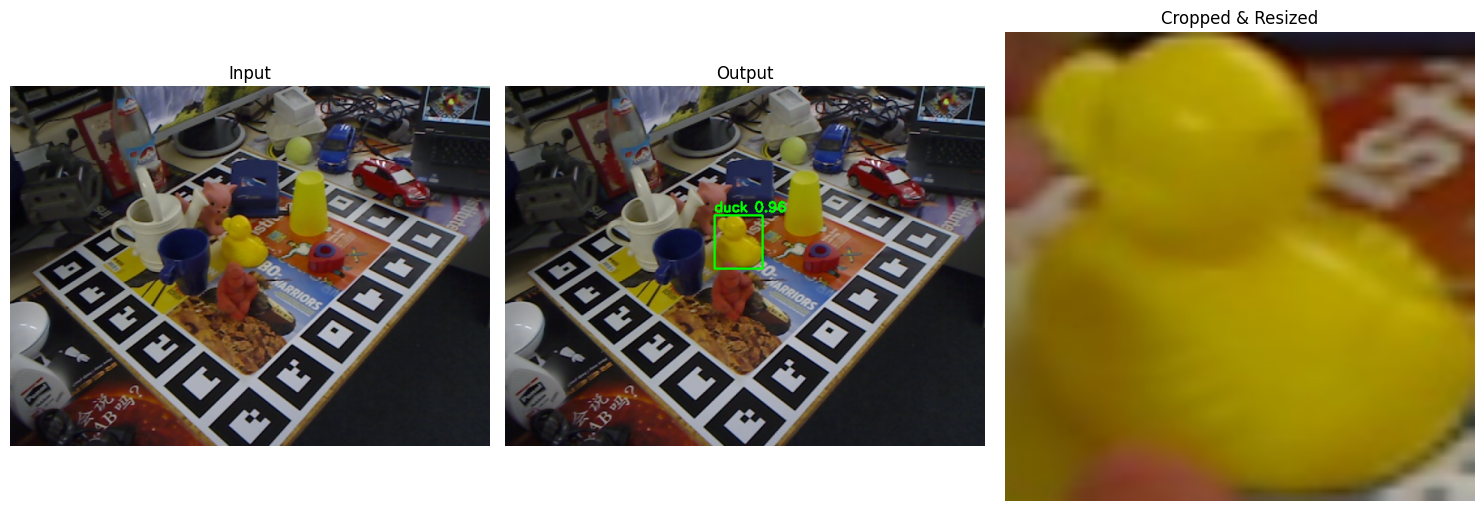

In [ ]:
# --- Configuration ---
model_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/weights/best.pt"
img_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/yolo_data/images/val/09_0654.png"
class_names = ['ape', 'benchvise', 'camera', 'can', 'cat', 'driller',
               'duck', 'eggbox', 'glue', 'holepuncher', 'iron', 'lamp', 'phone']
target_size = (256, 256)  # for crop+resize

# --- Load model and image ---
model = YOLO(model_path)
original_bgr = cv2.imread(img_path)
original_rgb = cv2.cvtColor(original_bgr, cv2.COLOR_BGR2RGB)
output_image = original_rgb.copy()

# --- Run YOLOv10m ---
results = model(img_path, verbose=False)[0]

# --- Draw predictions and extract crop ---
img_h, img_w = original_rgb.shape[:2]
cropped_resized = None

if results.boxes:
    box = results.boxes[0]
    cls = int(box.cls)
    conf = float(box.conf)
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())

    # Draw prediction (green)
    label = f"{class_names[cls]} {conf:.2f}"
    cv2.rectangle(output_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(output_image, label, (x1, y1 - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    # Crop and resize
    crop = original_rgb[y1:y2, x1:x2]
    cropped_resized = cv2.resize(crop, target_size, interpolation=cv2.INTER_LINEAR)

# --- Show all three images ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_rgb)
plt.title("Input")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(output_image)
plt.title("Output")
plt.axis("off")

if cropped_resized is not None:
    plt.subplot(1, 3, 3)
    plt.imshow(cropped_resized)
    plt.title("Cropped & Resized")
    plt.axis("off")

plt.tight_layout()
plt.show()


## **Visualization of YOLOv10m Detections with Confidence Overlays**


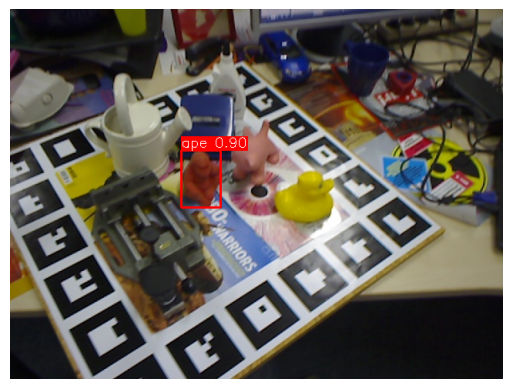

In [ ]:
# Load trained model
model_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/weights/best.pt"
model = YOLO(model_path)

# Path to image
img_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/yolo_data/images/val/01_0174.png"

# Class names
class_names = ['ape', 'benchvise', 'camera', 'can', 'cat',
               'driller', 'duck', 'eggbox', 'glue', 'holepuncher',
               'iron', 'lamp', 'phone']

# Run inference
results = model(img_path, verbose=False)[0]

# Load image
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Draw predictions with confidence
for box in results.boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cls_id = int(box.cls)
    conf = float(box.conf)
    label = f"{class_names[cls_id]} {conf:.2f}"

    # Draw rectangle
    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)

    # Draw label with confidence
    (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)
    cv2.rectangle(img_rgb, (x1, y1 - text_h - 4), (x1 + text_w, y1), (255, 0, 0), -1)
    cv2.putText(img_rgb, label, (x1, y1 - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

# Display only the image
plt.imshow(img_rgb)
plt.axis('off')
plt.savefig("yolo_prediction.svg", format='svg', bbox_inches='tight', pad_inches=0)

plt.show()


## **Batch Prediction of Bounding Boxes via YOLO CLI**

This command invokes the Ultralytics YOLO prediction pipeline in a non-interactive, batch mode.

Predictions are saved as text files (.txt) containing the class index and box coordinates in YOLO format.

All outputs are organized under the given project and run name for easy review.

In [ ]:
!yolo predict \
  model=/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/weights/best.pt \
  source=/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images \
  save_txt=True \
  save_conf=False \
  save=False \
  max_det=1 \
  project=/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m \
  name=bbox_predictions

Streaming output truncated to the last 5000 lines.
image 9225/14220 /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images/11_0521.png: 480x640 1 glue, 247.7ms
image 9226/14220 /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images/11_0522.png: 480x640 1 glue, 240.0ms
image 9227/14220 /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images/11_0523.png: 480x640 1 glue, 232.7ms
image 9228/14220 /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images/11_0524.png: 480x640 1 glue, 261.8ms
image 9229/14220 /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images/11_0525.png: 480x640 1 glue, 258.4ms
image 9230/14220 /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images/11_0526.png: 480x640 1 glue, 271.5ms
image 9231/14220 /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images/11_0527.png: 480x640 1 glue, 244.8ms
image 9232/14220 /content/drive/MyDrive/MLDL/6

## **Checking for Missing Predictions**


In [ ]:
# === Set paths ===
image_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images"
label_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/bbox_predictions/labels"

# === Get filenames without extensions ===
image_names = sorted([f[:-4] for f in os.listdir(image_dir) if f.endswith(".png")])
label_names = sorted([f[:-4] for f in os.listdir(label_dir) if f.endswith(".txt")])

# === Compare ===
missing = list(set(image_names) - set(label_names))

print(f" Total images: {len(image_names)}")
print(f" Total predictions: {len(label_names)}")
print(f" Missing predictions: {len(missing)}")
if missing:
    print("Missing files:")
    for name in sorted(missing)[:10]:  # show first 10 only
        print(f"- {name}.png")

Total images: 14220
 Total predictions: 14211
 Missing predictions: 9
Missing files:
- 01_0357.png
- 04_1025.png
- 08_0876.png
- 09_0448.png
- 09_0765.png
- 09_1132.png
- 10_0438.png
- 10_1053.png
- 14_0556.png


### **Generate labels and visual bbox for missing images**

In [ ]:
# === Paths ===
image_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images"
label_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/bbox_predictions/labels"
gt_path = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/gt.json"

# === Load Ground Truth ===
with open(gt_path, 'r') as f:
    gt_data = json.load(f)

# === Missing Predictions ===
missing = [
  "01_0357.png", "04_1025.png", "08_0876.png", "09_0448.png", "09_0765.png",
   "09_1132.png", "10_0438.png", "10_1053.png", "14_0556.png"
]

# === Generate labels and visual bbox images ===
for img_name in missing:
    key = img_name.replace(".png", "")
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, key + ".txt")

    if key not in gt_data:
        print(f" {key} not found in gt.json")
        continue

    bbox = gt_data[key][2]
    class_id = int(key.split("_")[0]) - 1

    img = cv2.imread(img_path)
    if img is None:
        print(f" Cannot read {img_path}")
        continue
    h, w = img.shape[:2]

    # Write YOLO-format label
    x, y, bw, bh = bbox
    x_center = (x + bw / 2) / w
    y_center = (y + bh / 2) / h
    norm_w = bw / w
    norm_h = bh / h

    with open(label_path, "w") as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}\n")

print(" Missing labels and bbox-drawn images generated.")


 Missing labels and bbox-drawn images generated.


## **Checking for Missing Predictions**

In [ ]:
# === Set path ===
image_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/full_data/train/images"
label_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/bbox_predictions/labels"

# === Get filenames without extensions ===
image_names = sorted([f[:-4] for f in os.listdir(image_dir) if f.endswith(".png")])
label_names = sorted([f[:-4] for f in os.listdir(label_dir) if f.endswith(".txt")])

# === Compare ===
missing = list(set(image_names) - set(label_names))

print(f" Total images: {len(image_names)}")
print(f" Total predictions: {len(label_names)}")
print(f" Missing predictions: {len(missing)}")
if missing:
    print("Missing files:")
    for name in sorted(missing)[:10]:  # show first 10 only
        print(f"- {name}.png")


Total images: 14220
 Total predictions: 14220
 Missing predictions: 0


## **Checking for Multiple Detections on image**

In certain cases, the YOLO model may detect multiple objects within a single image.


In [ ]:
# Path to the YOLO predicted labels
labels_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/bbox_predictions/labels"

# Count files with more than one line
multi_line_files = []

for fname in os.listdir(labels_dir):
    if fname.endswith(".txt"):
        with open(os.path.join(labels_dir, fname), "r") as f:
            lines = f.readlines()
            if len(lines) > 1:
                multi_line_files.append(fname)

# Report
print(f" Total .txt files with more than one line: {len(multi_line_files)}")
print(" Sample files:", multi_line_files[:10])


Total .txt files with more than one line: 110
 Sample files: ['15_0174.txt', '15_0240.txt', '15_0354.txt', '15_0531.txt', '15_0708.txt', '15_0715.txt', '15_0729.txt', '15_1002.txt', '15_1028.txt', '15_1238.txt']


### **Filtering Predictions to a Single Box**


This code filters each label file to keep only the bounding box that matches the image’s true class. It rewrites the file with the first valid detection, ensuring each image has exactly one correct bounding box.




In [ ]:
# Class mapping
class_map = {
    '01': 0, '02': 1, '04': 2, '05': 3, '06': 4,
    '08': 5, '09': 6, '10': 7, '11': 8, '12': 9,
    '13': 10, '14': 11, '15': 12
}

# Path to prediction labels
labels_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/yolov10m/bbox_predictions/labels"

for fname in multi_line_files:
    class_folder = fname.split('_')[0]  # e.g. "04"
    true_class_id = class_map.get(class_folder)
    if true_class_id is None:
        continue  # skip unknown classes

    label_path = os.path.join(labels_dir, fname)

    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Keep only lines where class matches the expected class ID
    filtered = [line for line in lines if line.startswith(str(true_class_id) + " ")]

    if filtered:
        # Only keep the first matching box
        with open(label_path, 'w') as f:
            f.write(filtered[0])
    else:
        print(f" No match found for {fname}, file unchanged.")

## **Verifying That Only One Prediction Remains**


In [ ]:
# Recheck multi_line_files after filtering
still_multi = []

for fname in multi_line_files:
    path = os.path.join(labels_dir, fname)
    with open(path, "r") as f:
        lines = f.readlines()
        if len(lines) > 1:
            still_multi.append(fname)

# Report
if still_multi:
    print(f" Still unfixed: {len(still_multi)} files")
    print(" Example:", still_multi[:5])
else:
    print(" All files in multi_line_files now have only 1 line.")

 All files in multi_line_files now have only 1 line.


## **Inspecting a single prediction file**


In [ ]:
fname = "15_1238.txt"
class_map = {
    '01': 0, '02': 1, '04': 2, '05': 3, '06': 4,
    '08': 5, '09': 6, '10': 7, '11': 8, '12': 9,
    '13': 10, '14': 11, '15': 12
}

expected_class_id = class_map[fname.split('_')[0]]
label_path = os.path.join(labels_dir, fname)

with open(label_path, 'r') as f:
    lines = f.readlines()

print(f" Contents of {fname} ({len(lines)} line{'s' if len(lines) != 1 else ''}):")
for line in lines:
    print("", line.strip())

# Optional check
if not lines:
    print(" File is empty.")
elif not lines[0].startswith(str(expected_class_id) + " "):
    print(f" First prediction does NOT match expected class ID: {expected_class_id}")
else:
    print(" File has 1 line and matches expected class.")


 Contents of 15_1238.txt (1 line):
 12 0.535593 0.516585 0.178426 0.26613
 File has 1 line and matches expected class.

